In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


Loaded 159606 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 glggzinb


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-glggzinb:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.4


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                  | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/1870 [00:00<16:34,  1.88it/s]

  0%|▍                                                                                                                                         | 6/1870 [00:00<02:39, 11.67it/s]

  1%|▊                                                                                                                                        | 11/1870 [00:00<01:34, 19.72it/s]

  1%|█▏                                                                                                                                       | 16/1870 [00:00<01:11, 26.03it/s]

  1%|█▌                                                                                                                                       | 21/1870 [00:00<00:59, 30.84it/s]

  1%|█▉                                                                                                                                       | 26/1870 [00:01<00:53, 34.42it/s]

  2%|██▎                                                                                                                                      | 31/1870 [00:01<00:49, 37.06it/s]

  2%|██▋                                                                                                                                      | 36/1870 [00:01<00:47, 38.96it/s]

  2%|███                                                                                                                                      | 41/1870 [00:01<00:45, 40.31it/s]

  2%|███▎                                                                                                                                     | 46/1870 [00:01<00:44, 41.28it/s]

  3%|███▋                                                                                                                                     | 51/1870 [00:01<00:43, 41.97it/s]

  3%|████                                                                                                                                     | 56/1870 [00:01<00:42, 42.45it/s]

  3%|████▍                                                                                                                                    | 61/1870 [00:01<00:42, 42.79it/s]

  4%|████▊                                                                                                                                    | 66/1870 [00:02<00:41, 43.03it/s]

  4%|█████▏                                                                                                                                   | 71/1870 [00:02<00:41, 43.21it/s]

  4%|█████▌                                                                                                                                   | 76/1870 [00:02<00:41, 43.31it/s]

  4%|█████▉                                                                                                                                   | 81/1870 [00:02<00:41, 43.41it/s]

  5%|██████▎                                                                                                                                  | 86/1870 [00:02<00:41, 43.46it/s]

  5%|██████▋                                                                                                                                  | 91/1870 [00:02<00:40, 43.50it/s]

  5%|███████                                                                                                                                  | 96/1870 [00:02<00:40, 43.53it/s]

  5%|███████▎                                                                                                                                | 101/1870 [00:02<00:40, 43.56it/s]

  6%|███████▋                                                                                                                                | 106/1870 [00:02<00:40, 43.56it/s]

  6%|████████                                                                                                                                | 111/1870 [00:03<00:40, 43.59it/s]

  6%|████████▍                                                                                                                               | 116/1870 [00:03<00:40, 43.60it/s]

  6%|████████▊                                                                                                                               | 121/1870 [00:03<00:40, 43.59it/s]

  7%|█████████▏                                                                                                                              | 126/1870 [00:03<00:40, 43.59it/s]

  7%|█████████▌                                                                                                                              | 131/1870 [00:03<00:39, 43.59it/s]

  7%|█████████▉                                                                                                                              | 136/1870 [00:03<00:39, 43.59it/s]

  8%|██████████▎                                                                                                                             | 141/1870 [00:03<00:39, 43.61it/s]

  8%|██████████▌                                                                                                                             | 146/1870 [00:03<00:39, 43.62it/s]

  8%|██████████▉                                                                                                                             | 151/1870 [00:03<00:39, 43.63it/s]

  8%|███████████▎                                                                                                                            | 156/1870 [00:04<00:39, 43.61it/s]

  9%|███████████▋                                                                                                                            | 161/1870 [00:04<00:39, 43.62it/s]

  9%|████████████                                                                                                                            | 166/1870 [00:04<00:39, 43.62it/s]

  9%|████████████▍                                                                                                                           | 171/1870 [00:04<00:38, 43.62it/s]

  9%|████████████▊                                                                                                                           | 176/1870 [00:04<00:38, 43.60it/s]

 10%|█████████████▏                                                                                                                          | 181/1870 [00:04<00:38, 43.61it/s]

 10%|█████████████▌                                                                                                                          | 186/1870 [00:04<00:38, 43.63it/s]

 10%|█████████████▉                                                                                                                          | 191/1870 [00:04<00:38, 43.64it/s]

 10%|██████████████▎                                                                                                                         | 196/1870 [00:05<00:38, 43.63it/s]

 11%|██████████████▌                                                                                                                         | 201/1870 [00:05<00:38, 43.63it/s]

 11%|██████████████▉                                                                                                                         | 206/1870 [00:05<00:38, 43.63it/s]

 11%|███████████████▎                                                                                                                        | 211/1870 [00:05<00:38, 43.64it/s]

 12%|███████████████▋                                                                                                                        | 216/1870 [00:05<00:37, 43.64it/s]

 12%|████████████████                                                                                                                        | 221/1870 [00:05<00:37, 43.63it/s]

 12%|████████████████▍                                                                                                                       | 226/1870 [00:05<00:37, 43.64it/s]

 12%|████████████████▊                                                                                                                       | 231/1870 [00:05<00:37, 43.64it/s]

 13%|█████████████████▏                                                                                                                      | 236/1870 [00:05<00:37, 43.65it/s]

 13%|█████████████████▌                                                                                                                      | 241/1870 [00:06<00:37, 43.63it/s]

 13%|█████████████████▉                                                                                                                      | 246/1870 [00:06<00:37, 43.63it/s]

 13%|██████████████████▎                                                                                                                     | 251/1870 [00:06<00:37, 43.59it/s]

 14%|██████████████████▌                                                                                                                     | 256/1870 [00:06<00:37, 43.59it/s]

 14%|██████████████████▉                                                                                                                     | 261/1870 [00:06<00:36, 43.62it/s]

 14%|███████████████████▎                                                                                                                    | 266/1870 [00:06<00:36, 43.62it/s]

 14%|███████████████████▋                                                                                                                    | 271/1870 [00:06<00:36, 43.62it/s]

 15%|████████████████████                                                                                                                    | 276/1870 [00:06<00:36, 43.61it/s]

 15%|████████████████████▍                                                                                                                   | 281/1870 [00:06<00:36, 43.61it/s]

 15%|████████████████████▊                                                                                                                   | 286/1870 [00:07<00:36, 43.60it/s]

 16%|█████████████████████▏                                                                                                                  | 291/1870 [00:07<00:36, 43.63it/s]

 16%|█████████████████████▌                                                                                                                  | 296/1870 [00:07<00:36, 43.64it/s]

 16%|█████████████████████▉                                                                                                                  | 301/1870 [00:07<00:35, 43.63it/s]

 16%|██████████████████████▎                                                                                                                 | 306/1870 [00:07<00:35, 43.63it/s]

 17%|██████████████████████▌                                                                                                                 | 311/1870 [00:07<00:35, 43.64it/s]

 17%|██████████████████████▉                                                                                                                 | 316/1870 [00:07<00:35, 43.63it/s]

 17%|███████████████████████▎                                                                                                                | 321/1870 [00:07<00:35, 43.62it/s]

 17%|███████████████████████▋                                                                                                                | 326/1870 [00:07<00:35, 43.63it/s]

 18%|████████████████████████                                                                                                                | 331/1870 [00:08<00:35, 43.62it/s]

 18%|████████████████████████▍                                                                                                               | 336/1870 [00:08<00:35, 43.64it/s]

 18%|████████████████████████▊                                                                                                               | 341/1870 [00:08<00:35, 43.63it/s]

 19%|█████████████████████████▏                                                                                                              | 346/1870 [00:08<00:34, 43.62it/s]

 19%|█████████████████████████▌                                                                                                              | 351/1870 [00:08<00:34, 43.64it/s]

 19%|█████████████████████████▉                                                                                                              | 356/1870 [00:08<00:34, 43.64it/s]

 19%|██████████████████████████▎                                                                                                             | 361/1870 [00:08<00:34, 43.61it/s]

 20%|██████████████████████████▌                                                                                                             | 366/1870 [00:08<00:34, 43.62it/s]

 20%|██████████████████████████▉                                                                                                             | 371/1870 [00:09<00:34, 43.65it/s]

 20%|███████████████████████████▎                                                                                                            | 376/1870 [00:09<00:34, 43.64it/s]

 20%|███████████████████████████▋                                                                                                            | 381/1870 [00:09<00:34, 43.63it/s]

 21%|████████████████████████████                                                                                                            | 386/1870 [00:09<00:34, 43.63it/s]

 21%|████████████████████████████▍                                                                                                           | 391/1870 [00:09<00:33, 43.64it/s]

 21%|████████████████████████████▊                                                                                                           | 396/1870 [00:09<00:33, 43.63it/s]

 21%|█████████████████████████████▏                                                                                                          | 401/1870 [00:09<00:33, 43.61it/s]

 22%|█████████████████████████████▌                                                                                                          | 406/1870 [00:09<00:33, 43.58it/s]

 22%|█████████████████████████████▉                                                                                                          | 411/1870 [00:09<00:33, 43.60it/s]

 22%|██████████████████████████████▎                                                                                                         | 416/1870 [00:10<00:33, 43.61it/s]

 23%|██████████████████████████████▌                                                                                                         | 421/1870 [00:10<00:33, 43.61it/s]

 23%|██████████████████████████████▉                                                                                                         | 426/1870 [00:10<00:33, 43.63it/s]

 23%|███████████████████████████████▎                                                                                                        | 431/1870 [00:10<00:32, 43.64it/s]

 23%|███████████████████████████████▋                                                                                                        | 436/1870 [00:10<00:32, 43.63it/s]

 24%|████████████████████████████████                                                                                                        | 441/1870 [00:10<00:32, 43.61it/s]

 24%|████████████████████████████████▍                                                                                                       | 446/1870 [00:10<00:32, 43.63it/s]

 24%|████████████████████████████████▊                                                                                                       | 451/1870 [00:10<00:32, 43.63it/s]

 24%|█████████████████████████████████▏                                                                                                      | 456/1870 [00:10<00:32, 43.60it/s]

 25%|█████████████████████████████████▌                                                                                                      | 461/1870 [00:11<00:32, 43.60it/s]

 25%|█████████████████████████████████▉                                                                                                      | 466/1870 [00:11<00:32, 43.63it/s]

 25%|██████████████████████████████████▎                                                                                                     | 471/1870 [00:11<00:32, 43.62it/s]

 25%|██████████████████████████████████▌                                                                                                     | 476/1870 [00:11<00:31, 43.64it/s]

 26%|██████████████████████████████████▉                                                                                                     | 481/1870 [00:11<00:31, 43.63it/s]

 26%|███████████████████████████████████▎                                                                                                    | 486/1870 [00:11<00:31, 43.64it/s]

 26%|███████████████████████████████████▋                                                                                                    | 491/1870 [00:11<00:31, 43.65it/s]

 27%|████████████████████████████████████                                                                                                    | 496/1870 [00:11<00:31, 43.64it/s]

 27%|████████████████████████████████████▍                                                                                                   | 501/1870 [00:11<00:31, 43.62it/s]

 27%|████████████████████████████████████▊                                                                                                   | 506/1870 [00:12<00:31, 43.62it/s]

 27%|█████████████████████████████████████▏                                                                                                  | 511/1870 [00:12<00:31, 43.60it/s]

 28%|█████████████████████████████████████▌                                                                                                  | 516/1870 [00:12<00:31, 43.63it/s]

 28%|█████████████████████████████████████▉                                                                                                  | 521/1870 [00:12<00:30, 43.63it/s]

 28%|██████████████████████████████████████▎                                                                                                 | 526/1870 [00:12<00:30, 43.62it/s]

 28%|██████████████████████████████████████▌                                                                                                 | 531/1870 [00:12<00:30, 43.63it/s]

 29%|██████████████████████████████████████▉                                                                                                 | 536/1870 [00:12<00:30, 43.62it/s]

 29%|███████████████████████████████████████▎                                                                                                | 541/1870 [00:12<00:30, 43.64it/s]

 29%|███████████████████████████████████████▋                                                                                                | 546/1870 [00:13<00:30, 43.64it/s]

 29%|████████████████████████████████████████                                                                                                | 551/1870 [00:13<00:30, 43.65it/s]

 30%|████████████████████████████████████████▍                                                                                               | 556/1870 [00:13<00:30, 43.65it/s]

 30%|████████████████████████████████████████▊                                                                                               | 561/1870 [00:13<00:29, 43.66it/s]

 30%|█████████████████████████████████████████▏                                                                                              | 566/1870 [00:13<00:29, 43.65it/s]

 31%|█████████████████████████████████████████▌                                                                                              | 571/1870 [00:13<00:29, 43.65it/s]

 31%|█████████████████████████████████████████▉                                                                                              | 576/1870 [00:13<00:29, 43.61it/s]

 31%|██████████████████████████████████████████▎                                                                                             | 581/1870 [00:13<00:29, 43.63it/s]

 31%|██████████████████████████████████████████▌                                                                                             | 586/1870 [00:13<00:29, 43.62it/s]

 32%|██████████████████████████████████████████▉                                                                                             | 591/1870 [00:14<00:29, 43.63it/s]

 32%|███████████████████████████████████████████▎                                                                                            | 596/1870 [00:14<00:29, 43.65it/s]

 32%|███████████████████████████████████████████▋                                                                                            | 601/1870 [00:14<00:29, 43.65it/s]

 32%|████████████████████████████████████████████                                                                                            | 606/1870 [00:14<00:28, 43.64it/s]

 33%|████████████████████████████████████████████▍                                                                                           | 611/1870 [00:14<00:28, 43.64it/s]

 33%|████████████████████████████████████████████▊                                                                                           | 616/1870 [00:14<00:28, 43.65it/s]

 33%|█████████████████████████████████████████████▏                                                                                          | 621/1870 [00:14<00:28, 43.65it/s]

 33%|█████████████████████████████████████████████▌                                                                                          | 626/1870 [00:14<00:28, 43.66it/s]

 34%|█████████████████████████████████████████████▉                                                                                          | 631/1870 [00:14<00:28, 43.65it/s]

 34%|██████████████████████████████████████████████▎                                                                                         | 636/1870 [00:15<00:28, 43.66it/s]

 34%|██████████████████████████████████████████████▌                                                                                         | 641/1870 [00:15<00:28, 43.65it/s]

 35%|██████████████████████████████████████████████▉                                                                                         | 646/1870 [00:15<00:28, 43.62it/s]

 35%|███████████████████████████████████████████████▎                                                                                        | 651/1870 [00:15<00:27, 43.63it/s]

 35%|███████████████████████████████████████████████▋                                                                                        | 656/1870 [00:15<00:27, 43.62it/s]

 35%|████████████████████████████████████████████████                                                                                        | 661/1870 [00:15<00:27, 43.63it/s]

 36%|████████████████████████████████████████████████▍                                                                                       | 666/1870 [00:15<00:27, 43.62it/s]

 36%|████████████████████████████████████████████████▊                                                                                       | 671/1870 [00:15<00:27, 43.63it/s]

 36%|█████████████████████████████████████████████████▏                                                                                      | 676/1870 [00:16<00:27, 43.64it/s]

 36%|█████████████████████████████████████████████████▌                                                                                      | 681/1870 [00:16<00:27, 43.64it/s]

 37%|█████████████████████████████████████████████████▉                                                                                      | 686/1870 [00:16<00:27, 43.64it/s]

 37%|██████████████████████████████████████████████████▎                                                                                     | 691/1870 [00:16<00:27, 43.64it/s]

 37%|██████████████████████████████████████████████████▌                                                                                     | 696/1870 [00:16<00:26, 43.63it/s]

 37%|██████████████████████████████████████████████████▉                                                                                     | 701/1870 [00:16<00:27, 42.65it/s]

 38%|███████████████████████████████████████████████████▎                                                                                    | 706/1870 [00:16<00:27, 42.93it/s]

 38%|███████████████████████████████████████████████████▋                                                                                    | 711/1870 [00:16<00:26, 43.15it/s]

 38%|████████████████████████████████████████████████████                                                                                    | 716/1870 [00:16<00:26, 43.30it/s]

 39%|████████████████████████████████████████████████████▍                                                                                   | 721/1870 [00:17<00:26, 43.40it/s]

 39%|████████████████████████████████████████████████████▊                                                                                   | 726/1870 [00:17<00:26, 43.47it/s]

 39%|█████████████████████████████████████████████████████▏                                                                                  | 731/1870 [00:17<00:26, 43.48it/s]

 39%|█████████████████████████████████████████████████████▌                                                                                  | 736/1870 [00:17<00:26, 43.52it/s]

 40%|█████████████████████████████████████████████████████▉                                                                                  | 741/1870 [00:17<00:25, 43.57it/s]

 40%|██████████████████████████████████████████████████████▎                                                                                 | 746/1870 [00:17<00:25, 43.59it/s]

 40%|██████████████████████████████████████████████████████▌                                                                                 | 751/1870 [00:17<00:25, 43.59it/s]

 40%|██████████████████████████████████████████████████████▉                                                                                 | 756/1870 [00:17<00:25, 43.59it/s]

 41%|███████████████████████████████████████████████████████▎                                                                                | 761/1870 [00:17<00:25, 43.60it/s]

 41%|███████████████████████████████████████████████████████▋                                                                                | 766/1870 [00:18<00:25, 43.62it/s]

 41%|████████████████████████████████████████████████████████                                                                                | 771/1870 [00:18<00:25, 43.63it/s]

 41%|████████████████████████████████████████████████████████▍                                                                               | 776/1870 [00:18<00:25, 43.64it/s]

 42%|████████████████████████████████████████████████████████▊                                                                               | 781/1870 [00:18<00:24, 43.61it/s]

 42%|█████████████████████████████████████████████████████████▏                                                                              | 786/1870 [00:18<00:24, 43.63it/s]

 42%|█████████████████████████████████████████████████████████▌                                                                              | 791/1870 [00:18<00:24, 43.62it/s]

 43%|█████████████████████████████████████████████████████████▉                                                                              | 796/1870 [00:18<00:24, 43.63it/s]

 43%|██████████████████████████████████████████████████████████▎                                                                             | 801/1870 [00:18<00:24, 43.64it/s]

 43%|██████████████████████████████████████████████████████████▌                                                                             | 806/1870 [00:18<00:24, 43.65it/s]

 43%|██████████████████████████████████████████████████████████▉                                                                             | 811/1870 [00:19<00:24, 43.65it/s]

 44%|███████████████████████████████████████████████████████████▎                                                                            | 816/1870 [00:19<00:24, 43.64it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                            | 821/1870 [00:19<00:24, 43.56it/s]

 44%|████████████████████████████████████████████████████████████                                                                            | 826/1870 [00:19<00:23, 43.58it/s]

 44%|████████████████████████████████████████████████████████████▍                                                                           | 831/1870 [00:19<00:23, 43.59it/s]

 45%|████████████████████████████████████████████████████████████▊                                                                           | 836/1870 [00:19<00:23, 43.59it/s]

 45%|█████████████████████████████████████████████████████████████▏                                                                          | 841/1870 [00:19<00:23, 43.61it/s]

 45%|█████████████████████████████████████████████████████████████▌                                                                          | 846/1870 [00:19<00:23, 43.61it/s]

 46%|█████████████████████████████████████████████████████████████▉                                                                          | 851/1870 [00:20<00:23, 43.62it/s]

 46%|██████████████████████████████████████████████████████████████▎                                                                         | 856/1870 [00:20<00:23, 43.61it/s]

 46%|██████████████████████████████████████████████████████████████▌                                                                         | 861/1870 [00:20<00:23, 43.63it/s]

 46%|██████████████████████████████████████████████████████████████▉                                                                         | 866/1870 [00:20<00:23, 43.64it/s]

 47%|███████████████████████████████████████████████████████████████▎                                                                        | 871/1870 [00:20<00:22, 43.65it/s]

 47%|███████████████████████████████████████████████████████████████▋                                                                        | 876/1870 [00:20<00:22, 43.65it/s]

 47%|████████████████████████████████████████████████████████████████                                                                        | 881/1870 [00:20<00:22, 43.64it/s]

 47%|████████████████████████████████████████████████████████████████▍                                                                       | 886/1870 [00:20<00:22, 43.63it/s]

 48%|████████████████████████████████████████████████████████████████▊                                                                       | 891/1870 [00:20<00:22, 43.63it/s]

 48%|█████████████████████████████████████████████████████████████████▏                                                                      | 896/1870 [00:21<00:22, 43.63it/s]

 48%|█████████████████████████████████████████████████████████████████▌                                                                      | 901/1870 [00:21<00:22, 43.65it/s]

 48%|█████████████████████████████████████████████████████████████████▉                                                                      | 906/1870 [00:21<00:22, 43.64it/s]

 49%|██████████████████████████████████████████████████████████████████▎                                                                     | 911/1870 [00:21<00:21, 43.64it/s]

 49%|██████████████████████████████████████████████████████████████████▌                                                                     | 916/1870 [00:21<00:21, 43.65it/s]

 49%|██████████████████████████████████████████████████████████████████▉                                                                     | 921/1870 [00:21<00:21, 43.55it/s]

 50%|███████████████████████████████████████████████████████████████████▎                                                                    | 926/1870 [00:21<00:21, 43.59it/s]

 50%|███████████████████████████████████████████████████████████████████▋                                                                    | 931/1870 [00:21<00:21, 43.61it/s]

 50%|████████████████████████████████████████████████████████████████████                                                                    | 936/1870 [00:21<00:21, 43.63it/s]

 50%|████████████████████████████████████████████████████████████████████▍                                                                   | 941/1870 [00:22<00:21, 43.64it/s]

 51%|████████████████████████████████████████████████████████████████████▊                                                                   | 946/1870 [00:22<00:21, 43.64it/s]

 51%|█████████████████████████████████████████████████████████████████████▏                                                                  | 951/1870 [00:22<00:21, 43.61it/s]

 51%|█████████████████████████████████████████████████████████████████████▌                                                                  | 956/1870 [00:22<00:20, 43.59it/s]

 51%|█████████████████████████████████████████████████████████████████████▉                                                                  | 961/1870 [00:22<00:20, 43.61it/s]

 52%|██████████████████████████████████████████████████████████████████████▎                                                                 | 966/1870 [00:22<00:20, 43.61it/s]

 52%|██████████████████████████████████████████████████████████████████████▌                                                                 | 971/1870 [00:22<00:20, 43.64it/s]

 52%|██████████████████████████████████████████████████████████████████████▉                                                                 | 976/1870 [00:22<00:20, 43.64it/s]

 52%|███████████████████████████████████████████████████████████████████████▎                                                                | 981/1870 [00:23<00:20, 43.64it/s]

 53%|███████████████████████████████████████████████████████████████████████▋                                                                | 986/1870 [00:23<00:20, 43.64it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                | 991/1870 [00:23<00:20, 43.63it/s]

 53%|████████████████████████████████████████████████████████████████████████▍                                                               | 996/1870 [00:23<00:20, 43.64it/s]

 54%|████████████████████████████████████████████████████████████████████████▎                                                              | 1001/1870 [00:23<00:19, 43.65it/s]

 54%|████████████████████████████████████████████████████████████████████████▋                                                              | 1006/1870 [00:23<00:19, 43.65it/s]

 54%|████████████████████████████████████████████████████████████████████████▉                                                              | 1011/1870 [00:23<00:19, 43.65it/s]

 54%|█████████████████████████████████████████████████████████████████████████▎                                                             | 1016/1870 [00:23<00:19, 43.64it/s]

 55%|█████████████████████████████████████████████████████████████████████████▋                                                             | 1021/1870 [00:23<00:19, 43.65it/s]

 55%|██████████████████████████████████████████████████████████████████████████                                                             | 1026/1870 [00:24<00:19, 43.64it/s]

 55%|██████████████████████████████████████████████████████████████████████████▍                                                            | 1031/1870 [00:24<00:19, 43.63it/s]

 55%|██████████████████████████████████████████████████████████████████████████▊                                                            | 1036/1870 [00:24<00:19, 43.64it/s]

 56%|███████████████████████████████████████████████████████████████████████████▏                                                           | 1041/1870 [00:24<00:19, 43.58it/s]

 56%|███████████████████████████████████████████████████████████████████████████▌                                                           | 1046/1870 [00:24<00:18, 43.60it/s]

 56%|███████████████████████████████████████████████████████████████████████████▊                                                           | 1051/1870 [00:24<00:18, 43.63it/s]

 56%|████████████████████████████████████████████████████████████████████████████▏                                                          | 1056/1870 [00:24<00:18, 43.63it/s]

 57%|████████████████████████████████████████████████████████████████████████████▌                                                          | 1061/1870 [00:24<00:18, 43.64it/s]

 57%|████████████████████████████████████████████████████████████████████████████▉                                                          | 1066/1870 [00:24<00:18, 43.63it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▎                                                         | 1071/1870 [00:25<00:18, 43.63it/s]

 58%|█████████████████████████████████████████████████████████████████████████████▋                                                         | 1076/1870 [00:25<00:18, 43.64it/s]

 58%|██████████████████████████████████████████████████████████████████████████████                                                         | 1081/1870 [00:25<00:18, 43.64it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▍                                                        | 1086/1870 [00:25<00:17, 43.64it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▊                                                        | 1091/1870 [00:25<00:17, 43.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████                                                        | 1096/1870 [00:25<00:17, 43.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▍                                                       | 1101/1870 [00:25<00:17, 43.64it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▊                                                       | 1106/1870 [00:25<00:17, 43.64it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▏                                                      | 1111/1870 [00:25<00:17, 43.64it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▌                                                      | 1116/1870 [00:26<00:17, 43.65it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▉                                                      | 1121/1870 [00:26<00:17, 43.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▎                                                     | 1126/1870 [00:26<00:17, 43.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▋                                                     | 1131/1870 [00:26<00:16, 43.64it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████                                                     | 1136/1870 [00:26<00:16, 43.63it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▎                                                    | 1141/1870 [00:26<00:16, 43.62it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▋                                                    | 1146/1870 [00:26<00:16, 43.64it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████                                                    | 1151/1870 [00:26<00:16, 43.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▍                                                   | 1156/1870 [00:27<00:16, 43.66it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████▊                                                   | 1161/1870 [00:27<00:16, 43.66it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1166/1870 [00:27<00:16, 43.64it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1171/1870 [00:27<00:16, 43.55it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1176/1870 [00:27<00:15, 43.56it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1181/1870 [00:27<00:15, 43.61it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1186/1870 [00:27<00:15, 43.60it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1191/1870 [00:27<00:15, 43.61it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▎                                                | 1196/1870 [00:27<00:15, 43.62it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▋                                                | 1201/1870 [00:28<00:15, 43.62it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████                                                | 1206/1870 [00:28<00:15, 43.60it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▍                                               | 1211/1870 [00:28<00:15, 43.63it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 1216/1870 [00:28<00:14, 43.63it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1221/1870 [00:28<00:14, 43.64it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1226/1870 [00:28<00:14, 43.64it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1231/1870 [00:28<00:14, 43.65it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1236/1870 [00:28<00:14, 43.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1241/1870 [00:28<00:14, 43.65it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1246/1870 [00:29<00:14, 43.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1251/1870 [00:29<00:14, 43.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1256/1870 [00:29<00:14, 43.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████                                            | 1261/1870 [00:29<00:13, 43.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1266/1870 [00:29<00:13, 43.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1271/1870 [00:29<00:13, 43.63it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████                                           | 1276/1870 [00:29<00:13, 43.64it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1281/1870 [00:29<00:13, 43.65it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1286/1870 [00:29<00:13, 43.64it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1291/1870 [00:30<00:13, 43.63it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1296/1870 [00:30<00:13, 43.65it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1301/1870 [00:30<00:13, 43.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1306/1870 [00:30<00:12, 43.65it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1311/1870 [00:30<00:12, 43.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████                                        | 1316/1870 [00:30<00:12, 43.54it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1321/1870 [00:30<00:12, 43.58it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1326/1870 [00:30<00:12, 43.61it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1331/1870 [00:31<00:12, 43.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1336/1870 [00:31<00:12, 43.61it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1341/1870 [00:31<00:12, 43.63it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1346/1870 [00:31<00:12, 43.63it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1351/1870 [00:31<00:11, 43.64it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1356/1870 [00:31<00:11, 43.63it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1361/1870 [00:31<00:11, 43.64it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1366/1870 [00:31<00:11, 43.65it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1371/1870 [00:31<00:11, 43.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1376/1870 [00:32<00:11, 43.66it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1381/1870 [00:32<00:11, 43.67it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1386/1870 [00:32<00:11, 43.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1391/1870 [00:32<00:10, 43.66it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1396/1870 [00:32<00:10, 43.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1401/1870 [00:32<00:10, 43.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1406/1870 [00:32<00:10, 43.66it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1411/1870 [00:32<00:10, 43.65it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1416/1870 [00:32<00:10, 43.65it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1421/1870 [00:33<00:10, 43.65it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1426/1870 [00:33<00:10, 43.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1431/1870 [00:33<00:10, 43.64it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1436/1870 [00:33<00:09, 43.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1441/1870 [00:33<00:09, 43.66it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1446/1870 [00:33<00:09, 43.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1451/1870 [00:33<00:09, 43.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1456/1870 [00:33<00:09, 43.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1461/1870 [00:34<00:09, 43.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1466/1870 [00:34<00:09, 43.62it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1471/1870 [00:34<00:09, 43.64it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1476/1870 [00:34<00:09, 43.65it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1481/1870 [00:34<00:08, 43.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1486/1870 [00:34<00:08, 43.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1491/1870 [00:34<00:08, 43.60it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1496/1870 [00:34<00:08, 43.61it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1501/1870 [00:34<00:08, 43.61it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1506/1870 [00:35<00:08, 43.63it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1511/1870 [00:35<00:08, 43.64it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1516/1870 [00:35<00:08, 43.65it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1521/1870 [00:35<00:07, 43.65it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1526/1870 [00:35<00:07, 43.62it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1531/1870 [00:35<00:07, 43.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1536/1870 [00:35<00:07, 43.61it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1541/1870 [00:35<00:07, 43.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1546/1870 [00:35<00:07, 43.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1551/1870 [00:36<00:07, 43.61it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1556/1870 [00:36<00:07, 43.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1561/1870 [00:36<00:07, 43.62it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1566/1870 [00:36<00:06, 43.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1571/1870 [00:36<00:06, 43.62it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1576/1870 [00:36<00:06, 43.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1581/1870 [00:36<00:06, 43.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1586/1870 [00:36<00:06, 43.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1591/1870 [00:36<00:06, 43.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1596/1870 [00:37<00:06, 43.63it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1601/1870 [00:37<00:06, 43.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1606/1870 [00:37<00:06, 43.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1611/1870 [00:37<00:05, 43.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1616/1870 [00:37<00:05, 43.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1621/1870 [00:37<00:05, 43.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1626/1870 [00:37<00:05, 43.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1631/1870 [00:37<00:05, 43.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1636/1870 [00:38<00:05, 43.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1641/1870 [00:38<00:05, 43.64it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1646/1870 [00:38<00:05, 43.64it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1651/1870 [00:38<00:05, 43.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1656/1870 [00:38<00:04, 43.65it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1661/1870 [00:38<00:04, 43.67it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1666/1870 [00:38<00:04, 43.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1671/1870 [00:38<00:04, 43.58it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1676/1870 [00:38<00:04, 43.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1681/1870 [00:39<00:04, 43.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1686/1870 [00:39<00:04, 43.62it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1691/1870 [00:39<00:04, 43.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1696/1870 [00:39<00:03, 43.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1701/1870 [00:39<00:03, 43.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1706/1870 [00:39<00:03, 43.64it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1711/1870 [00:39<00:03, 43.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1716/1870 [00:39<00:03, 43.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1721/1870 [00:39<00:03, 43.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1726/1870 [00:40<00:03, 43.65it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1731/1870 [00:40<00:03, 43.65it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1736/1870 [00:40<00:03, 43.64it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1741/1870 [00:40<00:02, 43.65it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1746/1870 [00:40<00:02, 43.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1751/1870 [00:40<00:02, 43.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1756/1870 [00:40<00:02, 43.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1761/1870 [00:40<00:02, 43.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1766/1870 [00:40<00:02, 43.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1771/1870 [00:41<00:02, 43.61it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1776/1870 [00:41<00:02, 43.59it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1781/1870 [00:41<00:02, 43.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1786/1870 [00:41<00:01, 43.61it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1791/1870 [00:41<00:01, 43.61it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1796/1870 [00:41<00:01, 43.63it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1801/1870 [00:41<00:01, 43.64it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1806/1870 [00:41<00:01, 43.64it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1811/1870 [00:42<00:01, 43.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1816/1870 [00:42<00:01, 43.63it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1821/1870 [00:42<00:01, 43.63it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1826/1870 [00:42<00:01, 43.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1831/1870 [00:42<00:00, 43.65it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1836/1870 [00:42<00:00, 43.65it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1841/1870 [00:42<00:00, 43.66it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1846/1870 [00:42<00:00, 43.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1851/1870 [00:42<00:00, 43.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1856/1870 [00:43<00:00, 43.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1861/1870 [00:43<00:00, 43.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1866/1870 [00:43<00:00, 42.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:43<00:00, 43.06it/s]

train - OK


  0%|                                                                                                                                                   | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                                          | 1/468 [00:00<02:43,  2.86it/s]

  1%|█▊                                                                                                                                         | 6/468 [00:00<00:29, 15.79it/s]

  2%|███▏                                                                                                                                      | 11/468 [00:00<00:18, 24.43it/s]

  3%|████▋                                                                                                                                     | 16/468 [00:00<00:14, 30.28it/s]

  4%|██████▏                                                                                                                                   | 21/468 [00:00<00:13, 34.32it/s]

  6%|███████▋                                                                                                                                  | 26/468 [00:00<00:11, 37.09it/s]

  7%|█████████▏                                                                                                                                | 31/468 [00:01<00:11, 39.00it/s]

  8%|██████████▌                                                                                                                               | 36/468 [00:01<00:10, 40.37it/s]

  9%|████████████                                                                                                                              | 41/468 [00:01<00:10, 41.30it/s]

 10%|█████████████▌                                                                                                                            | 46/468 [00:01<00:10, 41.94it/s]

 11%|███████████████                                                                                                                           | 51/468 [00:01<00:09, 42.42it/s]

 12%|████████████████▌                                                                                                                         | 56/468 [00:01<00:09, 42.74it/s]

 13%|█████████████████▉                                                                                                                        | 61/468 [00:01<00:09, 42.96it/s]

 14%|███████████████████▍                                                                                                                      | 66/468 [00:01<00:09, 43.12it/s]

 15%|████████████████████▉                                                                                                                     | 71/468 [00:01<00:09, 43.25it/s]

 16%|██████████████████████▍                                                                                                                   | 76/468 [00:02<00:09, 43.31it/s]

 17%|███████████████████████▉                                                                                                                  | 81/468 [00:02<00:08, 43.36it/s]

 18%|█████████████████████████▎                                                                                                                | 86/468 [00:02<00:08, 43.42it/s]

 19%|██████████████████████████▊                                                                                                               | 91/468 [00:02<00:08, 43.45it/s]

 21%|████████████████████████████▎                                                                                                             | 96/468 [00:02<00:08, 43.45it/s]

 22%|█████████████████████████████▌                                                                                                           | 101/468 [00:02<00:08, 43.47it/s]

 23%|███████████████████████████████                                                                                                          | 106/468 [00:02<00:08, 43.46it/s]

 24%|████████████████████████████████▍                                                                                                        | 111/468 [00:02<00:08, 43.47it/s]

 25%|█████████████████████████████████▉                                                                                                       | 116/468 [00:02<00:08, 43.50it/s]

 26%|███████████████████████████████████▍                                                                                                     | 121/468 [00:03<00:07, 43.51it/s]

 27%|████████████████████████████████████▉                                                                                                    | 126/468 [00:03<00:07, 43.50it/s]

 28%|██████████████████████████████████████▎                                                                                                  | 131/468 [00:03<00:07, 43.52it/s]

 29%|███████████████████████████████████████▊                                                                                                 | 136/468 [00:03<00:07, 43.49it/s]

 30%|█████████████████████████████████████████▎                                                                                               | 141/468 [00:03<00:07, 43.51it/s]

 31%|██████████████████████████████████████████▋                                                                                              | 146/468 [00:03<00:07, 43.52it/s]

 32%|████████████████████████████████████████████▏                                                                                            | 151/468 [00:03<00:07, 43.50it/s]

 33%|█████████████████████████████████████████████▋                                                                                           | 156/468 [00:03<00:07, 43.47it/s]

 34%|███████████████████████████████████████████████▏                                                                                         | 161/468 [00:04<00:07, 43.48it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 166/468 [00:04<00:06, 43.49it/s]

 37%|██████████████████████████████████████████████████                                                                                       | 171/468 [00:04<00:06, 43.48it/s]

 38%|███████████████████████████████████████████████████▌                                                                                     | 176/468 [00:04<00:06, 43.42it/s]

 39%|████████████████████████████████████████████████████▉                                                                                    | 181/468 [00:04<00:06, 43.44it/s]

 40%|██████████████████████████████████████████████████████▍                                                                                  | 186/468 [00:04<00:06, 43.46it/s]

 41%|███████████████████████████████████████████████████████▉                                                                                 | 191/468 [00:04<00:06, 43.40it/s]

 42%|█████████████████████████████████████████████████████████▍                                                                               | 196/468 [00:04<00:06, 43.36it/s]

 43%|██████████████████████████████████████████████████████████▊                                                                              | 201/468 [00:04<00:06, 43.38it/s]

 44%|████████████████████████████████████████████████████████████▎                                                                            | 206/468 [00:05<00:06, 43.41it/s]

 45%|█████████████████████████████████████████████████████████████▊                                                                           | 211/468 [00:05<00:05, 43.45it/s]

 46%|███████████████████████████████████████████████████████████████▏                                                                         | 216/468 [00:05<00:05, 43.47it/s]

 47%|████████████████████████████████████████████████████████████████▋                                                                        | 221/468 [00:05<00:05, 43.43it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                      | 226/468 [00:05<00:05, 43.45it/s]

 49%|███████████████████████████████████████████████████████████████████▌                                                                     | 231/468 [00:05<00:05, 43.48it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                    | 236/468 [00:05<00:05, 43.48it/s]

 51%|██████████████████████████████████████████████████████████████████████▌                                                                  | 241/468 [00:05<00:05, 43.49it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                 | 246/468 [00:05<00:05, 43.50it/s]

 54%|█████████████████████████████████████████████████████████████████████████▍                                                               | 251/468 [00:06<00:05, 43.40it/s]

 55%|██████████████████████████████████████████████████████████████████████████▉                                                              | 256/468 [00:06<00:04, 43.43it/s]

 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 261/468 [00:06<00:04, 43.45it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▊                                                           | 266/468 [00:06<00:04, 43.45it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▎                                                         | 271/468 [00:06<00:04, 43.45it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▊                                                        | 276/468 [00:06<00:04, 43.47it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▎                                                      | 281/468 [00:06<00:04, 43.42it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▋                                                     | 286/468 [00:06<00:04, 43.44it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                   | 291/468 [00:07<00:04, 43.45it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 296/468 [00:07<00:03, 43.45it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████                                                 | 301/468 [00:07<00:03, 43.46it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▌                                               | 306/468 [00:07<00:03, 43.46it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                              | 311/468 [00:07<00:03, 43.47it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 316/468 [00:07<00:03, 43.48it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 321/468 [00:07<00:03, 43.47it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 326/468 [00:07<00:03, 43.48it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 331/468 [00:07<00:03, 43.49it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 336/468 [00:08<00:03, 43.48it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 341/468 [00:08<00:02, 43.48it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 346/468 [00:08<00:02, 43.48it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 351/468 [00:08<00:02, 43.49it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 356/468 [00:08<00:02, 43.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 361/468 [00:08<00:02, 43.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 366/468 [00:08<00:02, 43.47it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 371/468 [00:08<00:02, 43.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 376/468 [00:08<00:02, 43.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 381/468 [00:09<00:02, 43.49it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 386/468 [00:09<00:01, 43.50it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 391/468 [00:09<00:01, 43.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 396/468 [00:09<00:01, 43.49it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 401/468 [00:09<00:01, 43.49it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 406/468 [00:09<00:01, 43.45it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 411/468 [00:09<00:01, 43.47it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 416/468 [00:09<00:01, 43.47it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 421/468 [00:10<00:01, 43.47it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 426/468 [00:10<00:00, 43.47it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 431/468 [00:10<00:00, 43.48it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 436/468 [00:10<00:00, 43.48it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 441/468 [00:10<00:00, 43.42it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 446/468 [00:10<00:00, 43.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 451/468 [00:10<00:00, 43.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 456/468 [00:10<00:00, 43.43it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 461/468 [00:10<00:00, 43.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 466/468 [00:11<00:00, 43.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 41.66it/s]

val - OK


  0%|                                                                                                                                                  | 0/1247 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 1/1247 [00:00<08:19,  2.49it/s]

  0%|▋                                                                                                                                         | 6/1247 [00:00<01:26, 14.36it/s]

  1%|█▏                                                                                                                                       | 11/1247 [00:00<00:54, 22.85it/s]

  1%|█▊                                                                                                                                       | 16/1247 [00:00<00:42, 28.90it/s]

  2%|██▎                                                                                                                                      | 21/1247 [00:00<00:36, 33.18it/s]

  2%|██▊                                                                                                                                      | 26/1247 [00:00<00:33, 36.21it/s]

  2%|███▍                                                                                                                                     | 31/1247 [00:01<00:31, 38.36it/s]

  3%|███▉                                                                                                                                     | 36/1247 [00:01<00:30, 39.88it/s]

  3%|████▌                                                                                                                                    | 41/1247 [00:01<00:29, 40.95it/s]

  4%|█████                                                                                                                                    | 46/1247 [00:01<00:28, 41.70it/s]

  4%|█████▌                                                                                                                                   | 51/1247 [00:01<00:28, 42.23it/s]

  4%|██████▏                                                                                                                                  | 56/1247 [00:01<00:27, 42.58it/s]

  5%|██████▋                                                                                                                                  | 61/1247 [00:01<00:27, 42.85it/s]

  5%|███████▎                                                                                                                                 | 66/1247 [00:01<00:27, 43.02it/s]

  6%|███████▊                                                                                                                                 | 71/1247 [00:02<00:27, 43.15it/s]

  6%|████████▎                                                                                                                                | 76/1247 [00:02<00:27, 43.23it/s]

  6%|████████▉                                                                                                                                | 81/1247 [00:02<00:26, 43.31it/s]

  7%|█████████▍                                                                                                                               | 86/1247 [00:02<00:26, 43.31it/s]

  7%|█████████▉                                                                                                                               | 91/1247 [00:02<00:26, 43.36it/s]

  8%|██████████▌                                                                                                                              | 96/1247 [00:02<00:26, 43.38it/s]

  8%|███████████                                                                                                                             | 101/1247 [00:02<00:26, 43.41it/s]

  9%|███████████▌                                                                                                                            | 106/1247 [00:02<00:26, 43.41it/s]

  9%|████████████                                                                                                                            | 111/1247 [00:02<00:26, 43.43it/s]

  9%|████████████▋                                                                                                                           | 116/1247 [00:03<00:26, 43.44it/s]

 10%|█████████████▏                                                                                                                          | 121/1247 [00:03<00:25, 43.42it/s]

 10%|█████████████▋                                                                                                                          | 126/1247 [00:03<00:25, 43.43it/s]

 11%|██████████████▎                                                                                                                         | 131/1247 [00:03<00:25, 43.44it/s]

 11%|██████████████▊                                                                                                                         | 136/1247 [00:03<00:25, 43.45it/s]

 11%|███████████████▍                                                                                                                        | 141/1247 [00:03<00:25, 43.45it/s]

 12%|███████████████▉                                                                                                                        | 146/1247 [00:03<00:25, 43.46it/s]

 12%|████████████████▍                                                                                                                       | 151/1247 [00:03<00:25, 43.45it/s]

 13%|█████████████████                                                                                                                       | 156/1247 [00:03<00:25, 43.41it/s]

 13%|█████████████████▌                                                                                                                      | 161/1247 [00:04<00:25, 43.42it/s]

 13%|██████████████████                                                                                                                      | 166/1247 [00:04<00:24, 43.43it/s]

 14%|██████████████████▋                                                                                                                     | 171/1247 [00:04<00:24, 43.43it/s]

 14%|███████████████████▏                                                                                                                    | 176/1247 [00:04<00:24, 43.38it/s]

 15%|███████████████████▋                                                                                                                    | 181/1247 [00:04<00:24, 43.39it/s]

 15%|████████████████████▎                                                                                                                   | 186/1247 [00:04<00:24, 43.41it/s]

 15%|████████████████████▊                                                                                                                   | 191/1247 [00:04<00:24, 43.42it/s]

 16%|█████████████████████▍                                                                                                                  | 196/1247 [00:04<00:24, 43.38it/s]

 16%|█████████████████████▉                                                                                                                  | 201/1247 [00:05<00:24, 43.40it/s]

 17%|██████████████████████▍                                                                                                                 | 206/1247 [00:05<00:23, 43.42it/s]

 17%|███████████████████████                                                                                                                 | 211/1247 [00:05<00:23, 43.42it/s]

 17%|███████████████████████▌                                                                                                                | 216/1247 [00:05<00:23, 43.41it/s]

 18%|████████████████████████                                                                                                                | 221/1247 [00:05<00:23, 43.35it/s]

 18%|████████████████████████▋                                                                                                               | 226/1247 [00:05<00:23, 43.38it/s]

 19%|█████████████████████████▏                                                                                                              | 231/1247 [00:05<00:23, 43.41it/s]

 19%|█████████████████████████▋                                                                                                              | 236/1247 [00:05<00:23, 43.42it/s]

 19%|██████████████████████████▎                                                                                                             | 241/1247 [00:05<00:23, 43.44it/s]

 20%|██████████████████████████▊                                                                                                             | 246/1247 [00:06<00:23, 43.44it/s]

 20%|███████████████████████████▎                                                                                                            | 251/1247 [00:06<00:22, 43.37it/s]

 21%|███████████████████████████▉                                                                                                            | 256/1247 [00:06<00:22, 43.40it/s]

 21%|████████████████████████████▍                                                                                                           | 261/1247 [00:06<00:22, 43.42it/s]

 21%|█████████████████████████████                                                                                                           | 266/1247 [00:06<00:22, 43.43it/s]

 22%|█████████████████████████████▌                                                                                                          | 271/1247 [00:06<00:22, 43.43it/s]

 22%|██████████████████████████████                                                                                                          | 276/1247 [00:06<00:22, 43.44it/s]

 23%|██████████████████████████████▋                                                                                                         | 281/1247 [00:06<00:22, 43.39it/s]

 23%|███████████████████████████████▏                                                                                                        | 286/1247 [00:06<00:22, 43.47it/s]

 23%|███████████████████████████████▋                                                                                                        | 291/1247 [00:07<00:22, 43.45it/s]

 24%|████████████████████████████████▎                                                                                                       | 296/1247 [00:07<00:21, 43.42it/s]

 24%|████████████████████████████████▊                                                                                                       | 301/1247 [00:07<00:21, 43.43it/s]

 25%|█████████████████████████████████▎                                                                                                      | 306/1247 [00:07<00:21, 43.45it/s]

 25%|█████████████████████████████████▉                                                                                                      | 311/1247 [00:07<00:21, 43.46it/s]

 25%|██████████████████████████████████▍                                                                                                     | 316/1247 [00:07<00:21, 43.48it/s]

 26%|███████████████████████████████████                                                                                                     | 321/1247 [00:07<00:21, 43.46it/s]

 26%|███████████████████████████████████▌                                                                                                    | 326/1247 [00:07<00:21, 43.46it/s]

 27%|████████████████████████████████████                                                                                                    | 331/1247 [00:08<00:21, 43.45it/s]

 27%|████████████████████████████████████▋                                                                                                   | 336/1247 [00:08<00:20, 43.44it/s]

 27%|█████████████████████████████████████▏                                                                                                  | 341/1247 [00:08<00:20, 43.43it/s]

 28%|█████████████████████████████████████▋                                                                                                  | 346/1247 [00:08<00:20, 43.44it/s]

 28%|██████████████████████████████████████▎                                                                                                 | 351/1247 [00:08<00:20, 43.44it/s]

 29%|██████████████████████████████████████▊                                                                                                 | 356/1247 [00:08<00:20, 43.45it/s]

 29%|███████████████████████████████████████▎                                                                                                | 361/1247 [00:08<00:20, 43.38it/s]

 29%|███████████████████████████████████████▉                                                                                                | 366/1247 [00:08<00:20, 43.40it/s]

 30%|████████████████████████████████████████▍                                                                                               | 371/1247 [00:08<00:20, 43.41it/s]

 30%|█████████████████████████████████████████                                                                                               | 376/1247 [00:09<00:20, 43.41it/s]

 31%|█████████████████████████████████████████▌                                                                                              | 381/1247 [00:09<00:19, 43.45it/s]

 31%|██████████████████████████████████████████                                                                                              | 386/1247 [00:09<00:19, 43.45it/s]

 31%|██████████████████████████████████████████▋                                                                                             | 391/1247 [00:09<00:19, 43.44it/s]

 32%|███████████████████████████████████████████▏                                                                                            | 396/1247 [00:09<00:19, 43.44it/s]

 32%|███████████████████████████████████████████▋                                                                                            | 401/1247 [00:09<00:19, 43.44it/s]

 33%|████████████████████████████████████████████▎                                                                                           | 406/1247 [00:09<00:19, 43.40it/s]

 33%|████████████████████████████████████████████▊                                                                                           | 411/1247 [00:09<00:19, 43.44it/s]

 33%|█████████████████████████████████████████████▎                                                                                          | 416/1247 [00:09<00:19, 43.43it/s]

 34%|█████████████████████████████████████████████▉                                                                                          | 421/1247 [00:10<00:19, 43.43it/s]

 34%|██████████████████████████████████████████████▍                                                                                         | 426/1247 [00:10<00:18, 43.43it/s]

 35%|███████████████████████████████████████████████                                                                                         | 431/1247 [00:10<00:18, 43.43it/s]

 35%|███████████████████████████████████████████████▌                                                                                        | 436/1247 [00:10<00:18, 43.44it/s]

 35%|████████████████████████████████████████████████                                                                                        | 441/1247 [00:10<00:18, 43.44it/s]

 36%|████████████████████████████████████████████████▋                                                                                       | 446/1247 [00:10<00:18, 43.45it/s]

 36%|█████████████████████████████████████████████████▏                                                                                      | 451/1247 [00:10<00:18, 43.45it/s]

 37%|█████████████████████████████████████████████████▋                                                                                      | 456/1247 [00:10<00:18, 43.41it/s]

 37%|██████████████████████████████████████████████████▎                                                                                     | 461/1247 [00:10<00:18, 43.40it/s]

 37%|██████████████████████████████████████████████████▊                                                                                     | 466/1247 [00:11<00:17, 43.43it/s]

 38%|███████████████████████████████████████████████████▎                                                                                    | 471/1247 [00:11<00:17, 43.44it/s]

 38%|███████████████████████████████████████████████████▉                                                                                    | 476/1247 [00:11<00:17, 43.45it/s]

 39%|████████████████████████████████████████████████████▍                                                                                   | 481/1247 [00:11<00:17, 43.46it/s]

 39%|█████████████████████████████████████████████████████                                                                                   | 486/1247 [00:11<00:17, 43.46it/s]

 39%|█████████████████████████████████████████████████████▌                                                                                  | 491/1247 [00:11<00:17, 43.45it/s]

 40%|██████████████████████████████████████████████████████                                                                                  | 496/1247 [00:11<00:17, 43.46it/s]

 40%|██████████████████████████████████████████████████████▋                                                                                 | 501/1247 [00:11<00:17, 43.47it/s]

 41%|███████████████████████████████████████████████████████▏                                                                                | 506/1247 [00:12<00:17, 43.46it/s]

 41%|███████████████████████████████████████████████████████▋                                                                                | 511/1247 [00:12<00:16, 43.37it/s]

 41%|████████████████████████████████████████████████████████▎                                                                               | 516/1247 [00:12<00:16, 43.49it/s]

 42%|████████████████████████████████████████████████████████▊                                                                               | 521/1247 [00:12<00:16, 43.52it/s]

 42%|█████████████████████████████████████████████████████████▎                                                                              | 526/1247 [00:12<00:16, 43.51it/s]

 43%|█████████████████████████████████████████████████████████▉                                                                              | 531/1247 [00:12<00:16, 43.31it/s]

 43%|██████████████████████████████████████████████████████████▍                                                                             | 536/1247 [00:12<00:16, 43.34it/s]

 43%|███████████████████████████████████████████████████████████                                                                             | 541/1247 [00:12<00:16, 43.38it/s]

 44%|███████████████████████████████████████████████████████████▌                                                                            | 546/1247 [00:12<00:16, 43.41it/s]

 44%|████████████████████████████████████████████████████████████                                                                            | 551/1247 [00:13<00:16, 43.41it/s]

 45%|████████████████████████████████████████████████████████████▋                                                                           | 556/1247 [00:13<00:15, 43.43it/s]

 45%|█████████████████████████████████████████████████████████████▏                                                                          | 561/1247 [00:13<00:15, 43.44it/s]

 45%|█████████████████████████████████████████████████████████████▋                                                                          | 566/1247 [00:13<00:15, 43.44it/s]

 46%|██████████████████████████████████████████████████████████████▎                                                                         | 571/1247 [00:13<00:15, 43.46it/s]

 46%|██████████████████████████████████████████████████████████████▊                                                                         | 576/1247 [00:13<00:15, 43.44it/s]

 47%|███████████████████████████████████████████████████████████████▎                                                                        | 581/1247 [00:13<00:15, 43.51it/s]

 47%|███████████████████████████████████████████████████████████████▉                                                                        | 586/1247 [00:13<00:15, 43.49it/s]

 47%|████████████████████████████████████████████████████████████████▍                                                                       | 591/1247 [00:13<00:15, 43.48it/s]

 48%|█████████████████████████████████████████████████████████████████                                                                       | 596/1247 [00:14<00:14, 43.46it/s]

 48%|█████████████████████████████████████████████████████████████████▌                                                                      | 601/1247 [00:14<00:14, 43.43it/s]

 49%|██████████████████████████████████████████████████████████████████                                                                      | 606/1247 [00:14<00:14, 43.44it/s]

 49%|██████████████████████████████████████████████████████████████████▋                                                                     | 611/1247 [00:14<00:14, 43.45it/s]

 49%|███████████████████████████████████████████████████████████████████▏                                                                    | 616/1247 [00:14<00:14, 43.44it/s]

 50%|███████████████████████████████████████████████████████████████████▋                                                                    | 621/1247 [00:14<00:14, 43.44it/s]

 50%|████████████████████████████████████████████████████████████████████▎                                                                   | 626/1247 [00:14<00:14, 43.44it/s]

 51%|████████████████████████████████████████████████████████████████████▊                                                                   | 631/1247 [00:14<00:14, 43.43it/s]

 51%|█████████████████████████████████████████████████████████████████████▎                                                                  | 636/1247 [00:15<00:14, 43.44it/s]

 51%|█████████████████████████████████████████████████████████████████████▉                                                                  | 641/1247 [00:15<00:13, 43.45it/s]

 52%|██████████████████████████████████████████████████████████████████████▍                                                                 | 646/1247 [00:15<00:13, 43.39it/s]

 52%|██████████████████████████████████████████████████████████████████████▉                                                                 | 651/1247 [00:15<00:13, 43.46it/s]

 53%|███████████████████████████████████████████████████████████████████████▌                                                                | 656/1247 [00:15<00:13, 43.53it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                | 661/1247 [00:15<00:13, 43.51it/s]

 53%|████████████████████████████████████████████████████████████████████████▋                                                               | 666/1247 [00:15<00:13, 42.98it/s]

 54%|█████████████████████████████████████████████████████████████████████████▏                                                              | 671/1247 [00:15<00:13, 43.11it/s]

 54%|█████████████████████████████████████████████████████████████████████████▋                                                              | 676/1247 [00:15<00:13, 43.19it/s]

 55%|██████████████████████████████████████████████████████████████████████████▎                                                             | 681/1247 [00:16<00:13, 43.28it/s]

 55%|██████████████████████████████████████████████████████████████████████████▊                                                             | 686/1247 [00:16<00:12, 43.33it/s]

 55%|███████████████████████████████████████████████████████████████████████████▎                                                            | 691/1247 [00:16<00:12, 43.37it/s]

 56%|███████████████████████████████████████████████████████████████████████████▉                                                            | 696/1247 [00:16<00:12, 43.40it/s]

 56%|████████████████████████████████████████████████████████████████████████████▍                                                           | 701/1247 [00:16<00:12, 43.42it/s]

 57%|████████████████████████████████████████████████████████████████████████████▉                                                           | 706/1247 [00:16<00:12, 43.44it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▌                                                          | 711/1247 [00:16<00:12, 43.46it/s]

 57%|██████████████████████████████████████████████████████████████████████████████                                                          | 716/1247 [00:16<00:12, 43.46it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▋                                                         | 721/1247 [00:16<00:12, 43.45it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▏                                                        | 726/1247 [00:17<00:11, 43.45it/s]

 59%|███████████████████████████████████████████████████████████████████████████████▋                                                        | 731/1247 [00:17<00:11, 43.39it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▎                                                       | 736/1247 [00:17<00:11, 43.48it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▊                                                       | 741/1247 [00:17<00:11, 43.48it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▎                                                      | 746/1247 [00:17<00:11, 43.47it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▉                                                      | 751/1247 [00:17<00:11, 43.46it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▍                                                     | 756/1247 [00:17<00:11, 43.47it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                     | 761/1247 [00:17<00:11, 43.44it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▌                                                    | 766/1247 [00:18<00:11, 43.42it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████                                                    | 771/1247 [00:18<00:10, 43.42it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▋                                                   | 776/1247 [00:18<00:10, 43.41it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▏                                                  | 781/1247 [00:18<00:10, 43.42it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████▋                                                  | 786/1247 [00:18<00:10, 43.42it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                 | 791/1247 [00:18<00:10, 43.43it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████▊                                                 | 796/1247 [00:18<00:10, 43.45it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▎                                                | 801/1247 [00:18<00:10, 43.03it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████▉                                                | 806/1247 [00:18<00:10, 43.15it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                               | 811/1247 [00:19<00:10, 43.24it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                               | 816/1247 [00:19<00:09, 43.32it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████▌                                              | 821/1247 [00:19<00:09, 43.31it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████                                              | 826/1247 [00:19<00:09, 43.44it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                             | 831/1247 [00:19<00:09, 43.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                            | 836/1247 [00:19<00:09, 43.54it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▋                                            | 841/1247 [00:19<00:09, 43.52it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 846/1247 [00:19<00:09, 43.50it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 851/1247 [00:19<00:09, 43.50it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 856/1247 [00:20<00:08, 43.48it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 861/1247 [00:20<00:08, 43.48it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 866/1247 [00:20<00:08, 43.47it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 871/1247 [00:20<00:08, 43.34it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 876/1247 [00:20<00:08, 43.38it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████                                        | 881/1247 [00:20<00:08, 43.41it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 886/1247 [00:20<00:08, 43.42it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 891/1247 [00:20<00:08, 43.43it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 896/1247 [00:21<00:08, 43.44it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 901/1247 [00:21<00:07, 43.45it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 906/1247 [00:21<00:07, 43.45it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 911/1247 [00:21<00:07, 43.46it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 916/1247 [00:21<00:07, 43.44it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 921/1247 [00:21<00:07, 43.39it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 926/1247 [00:21<00:07, 43.48it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 931/1247 [00:21<00:07, 43.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 936/1247 [00:21<00:07, 43.61it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 941/1247 [00:22<00:07, 43.65it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 946/1247 [00:22<00:06, 43.64it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 951/1247 [00:22<00:06, 43.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 956/1247 [00:22<00:06, 43.64it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 961/1247 [00:22<00:06, 43.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 966/1247 [00:22<00:06, 43.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 971/1247 [00:22<00:06, 43.48it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 976/1247 [00:22<00:06, 43.49it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 981/1247 [00:22<00:06, 43.46it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 986/1247 [00:23<00:06, 43.46it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 991/1247 [00:23<00:05, 43.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 996/1247 [00:23<00:05, 43.44it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1001/1247 [00:23<00:05, 43.41it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1006/1247 [00:23<00:05, 43.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1011/1247 [00:23<00:05, 43.44it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1016/1247 [00:23<00:05, 43.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1021/1247 [00:23<00:05, 43.43it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1026/1247 [00:24<00:05, 43.44it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1031/1247 [00:24<00:04, 43.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1036/1247 [00:24<00:04, 43.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1041/1247 [00:24<00:04, 43.44it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1046/1247 [00:24<00:04, 43.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1051/1247 [00:24<00:04, 43.60it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1056/1247 [00:24<00:04, 43.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1061/1247 [00:24<00:04, 43.66it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1066/1247 [00:24<00:04, 43.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1071/1247 [00:25<00:04, 43.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1076/1247 [00:25<00:03, 43.69it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1081/1247 [00:25<00:03, 43.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1086/1247 [00:25<00:03, 43.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1091/1247 [00:25<00:03, 43.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1096/1247 [00:25<00:03, 43.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1101/1247 [00:25<00:03, 43.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1106/1247 [00:25<00:03, 43.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1111/1247 [00:25<00:03, 43.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1116/1247 [00:26<00:03, 43.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1121/1247 [00:26<00:02, 43.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1126/1247 [00:26<00:02, 43.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1131/1247 [00:26<00:02, 43.45it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1136/1247 [00:26<00:02, 43.46it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1141/1247 [00:26<00:02, 43.45it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1146/1247 [00:26<00:02, 43.45it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1151/1247 [00:26<00:02, 43.45it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1156/1247 [00:26<00:02, 43.45it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1161/1247 [00:27<00:01, 43.45it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1166/1247 [00:27<00:01, 43.44it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1171/1247 [00:27<00:01, 43.41it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1176/1247 [00:27<00:01, 43.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1181/1247 [00:27<00:01, 43.57it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1186/1247 [00:27<00:01, 43.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1191/1247 [00:27<00:01, 43.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1196/1247 [00:27<00:01, 43.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1201/1247 [00:28<00:01, 43.62it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1206/1247 [00:28<00:00, 43.57it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1211/1247 [00:28<00:00, 43.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1216/1247 [00:28<00:00, 43.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1221/1247 [00:28<00:00, 43.51it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1226/1247 [00:28<00:00, 43.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1231/1247 [00:28<00:00, 43.49it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1236/1247 [00:28<00:00, 43.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1241/1247 [00:28<00:00, 43.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1246/1247 [00:29<00:00, 43.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:29<00:00, 42.63it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  5%|██████▉                                                                                                                                    | 5/100 [00:00<00:02, 44.84it/s]

 10%|█████████████▊                                                                                                                            | 10/100 [00:00<00:02, 44.94it/s]

 15%|████████████████████▋                                                                                                                     | 15/100 [00:00<00:01, 45.01it/s]

 20%|███████████████████████████▌                                                                                                              | 20/100 [00:00<00:01, 45.04it/s]

 25%|██████████████████████████████████▌                                                                                                       | 25/100 [00:00<00:01, 45.05it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 45.09it/s]

 35%|████████████████████████████████████████████████▎                                                                                         | 35/100 [00:00<00:01, 45.11it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                  | 40/100 [00:00<00:01, 45.13it/s]

 45%|██████████████████████████████████████████████████████████████                                                                            | 45/100 [00:00<00:01, 45.14it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 50/100 [00:01<00:01, 45.15it/s]

 55%|███████████████████████████████████████████████████████████████████████████▉                                                              | 55/100 [00:01<00:00, 45.16it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 45.16it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                | 65/100 [00:01<00:00, 45.13it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 70/100 [00:01<00:00, 45.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 75/100 [00:01<00:00, 45.15it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 80/100 [00:01<00:00, 45.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 85/100 [00:01<00:00, 45.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 45.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 95/100 [00:02<00:00, 45.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.12it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(239318, 1, 64, 64) (239318, 1, 64, 64) (239318, 512) (239318, 4) (239318,)
(59836, 1, 64, 64) (59836, 1, 64, 64) (59836, 512) (59836, 4) (59836,)
(159606, 1, 64, 64) (159606, 1, 64, 64) (159606, 512) (159606, 4) (159606,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 4)


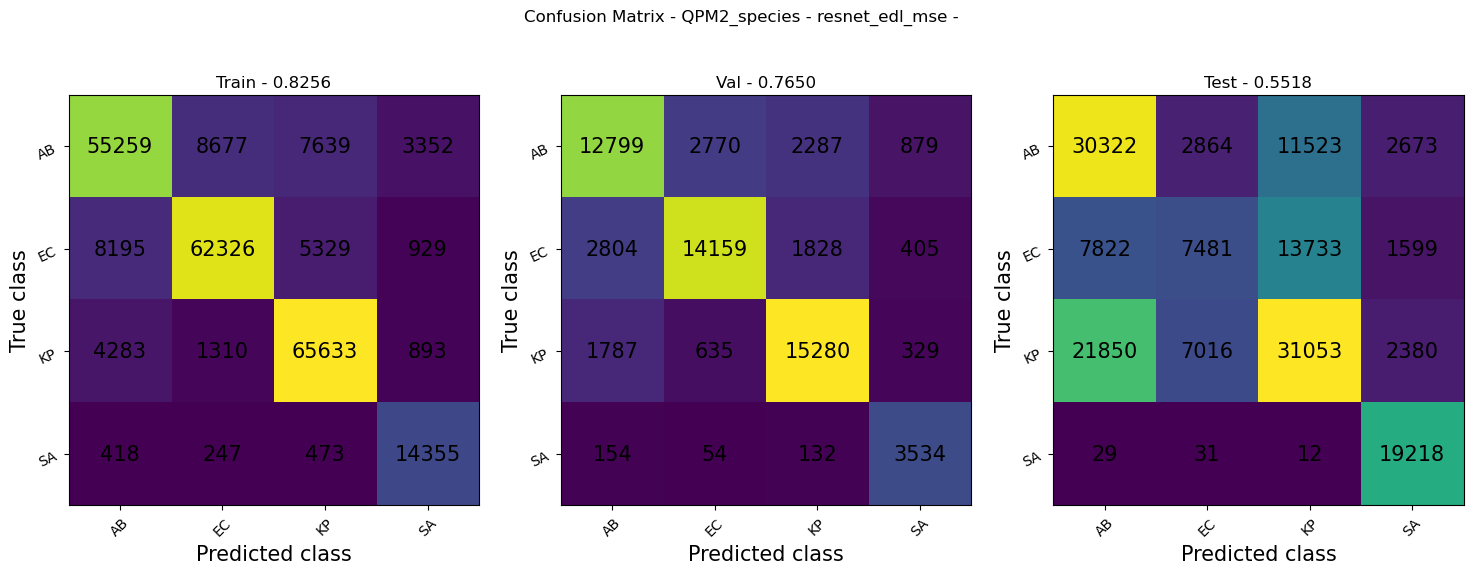

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(159606, 2) (0, 2)


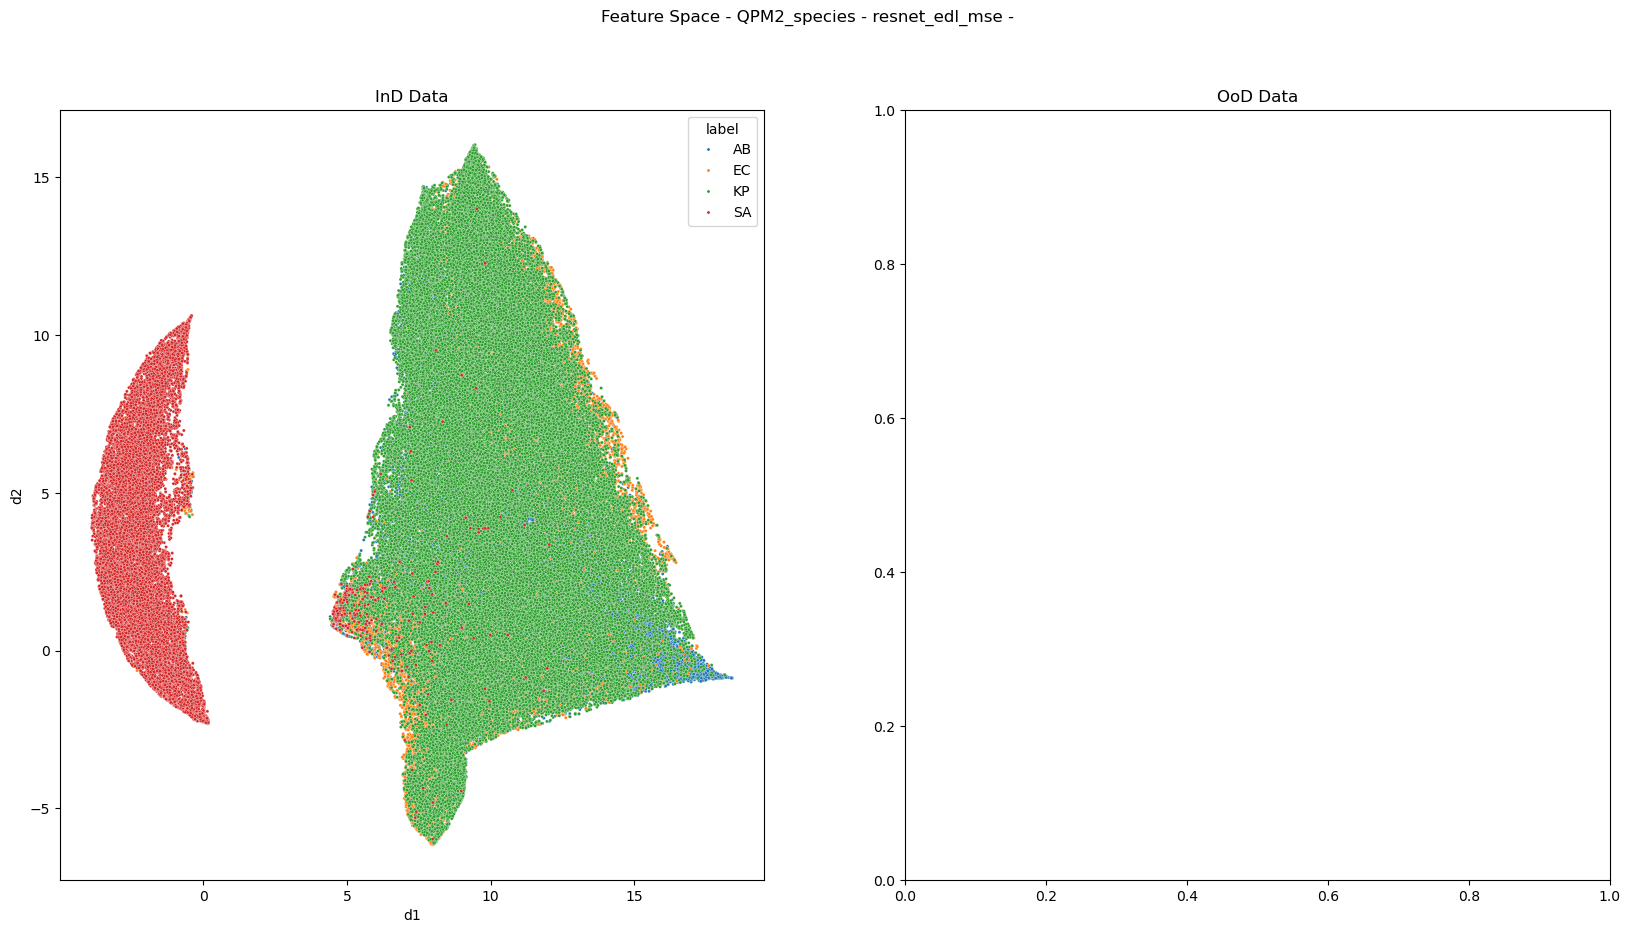

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

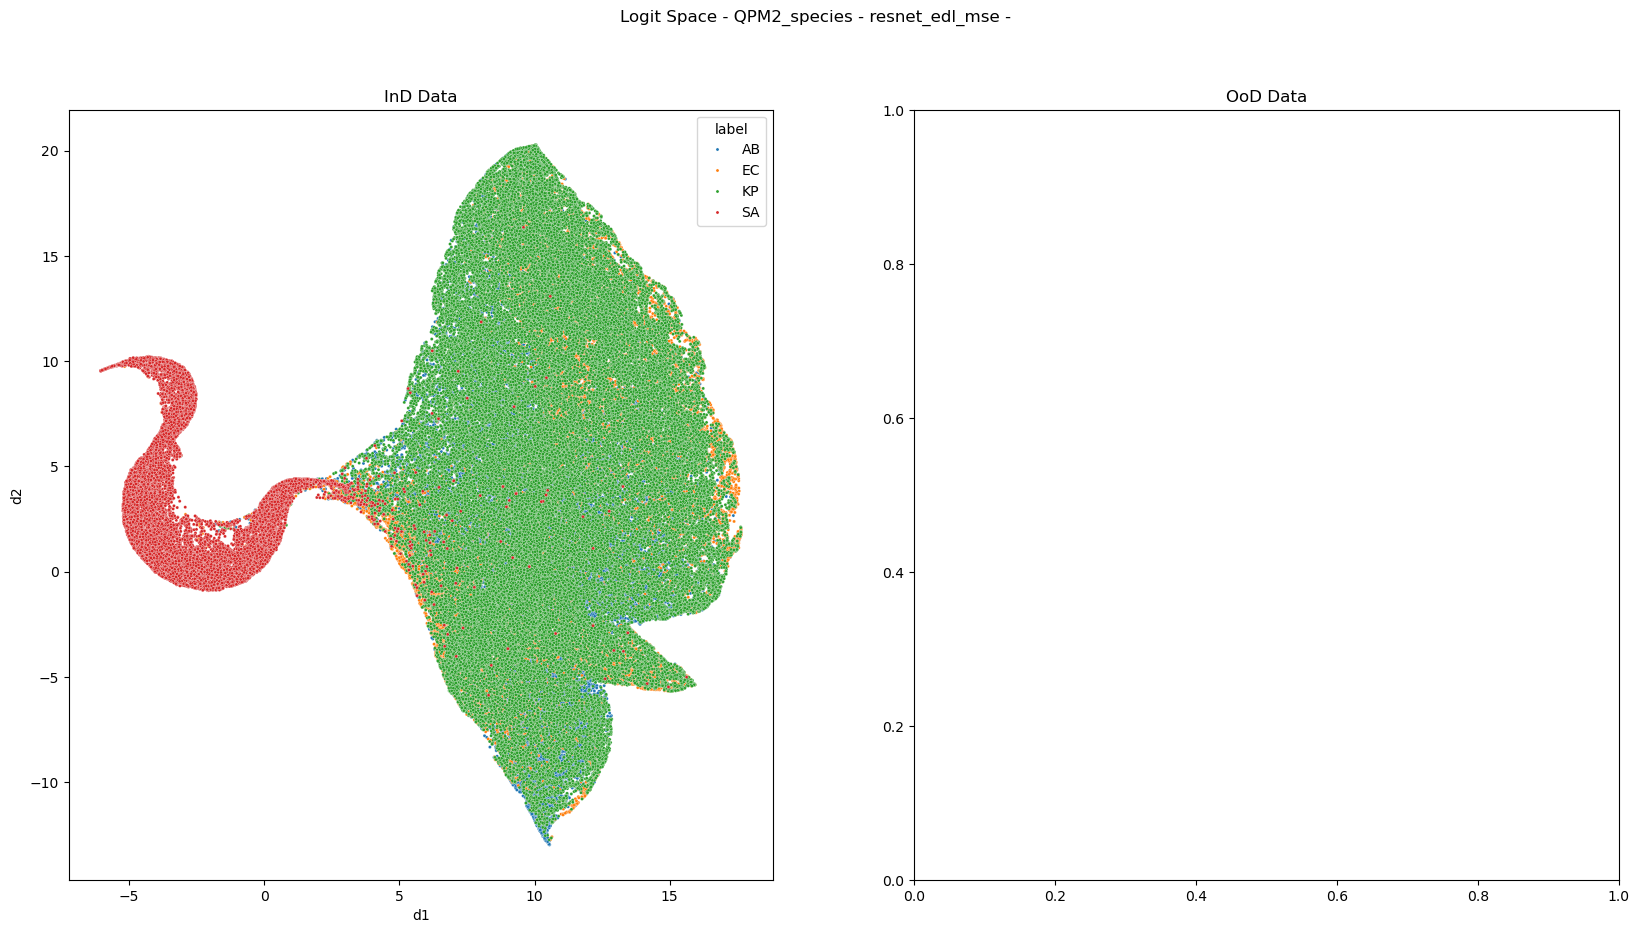

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

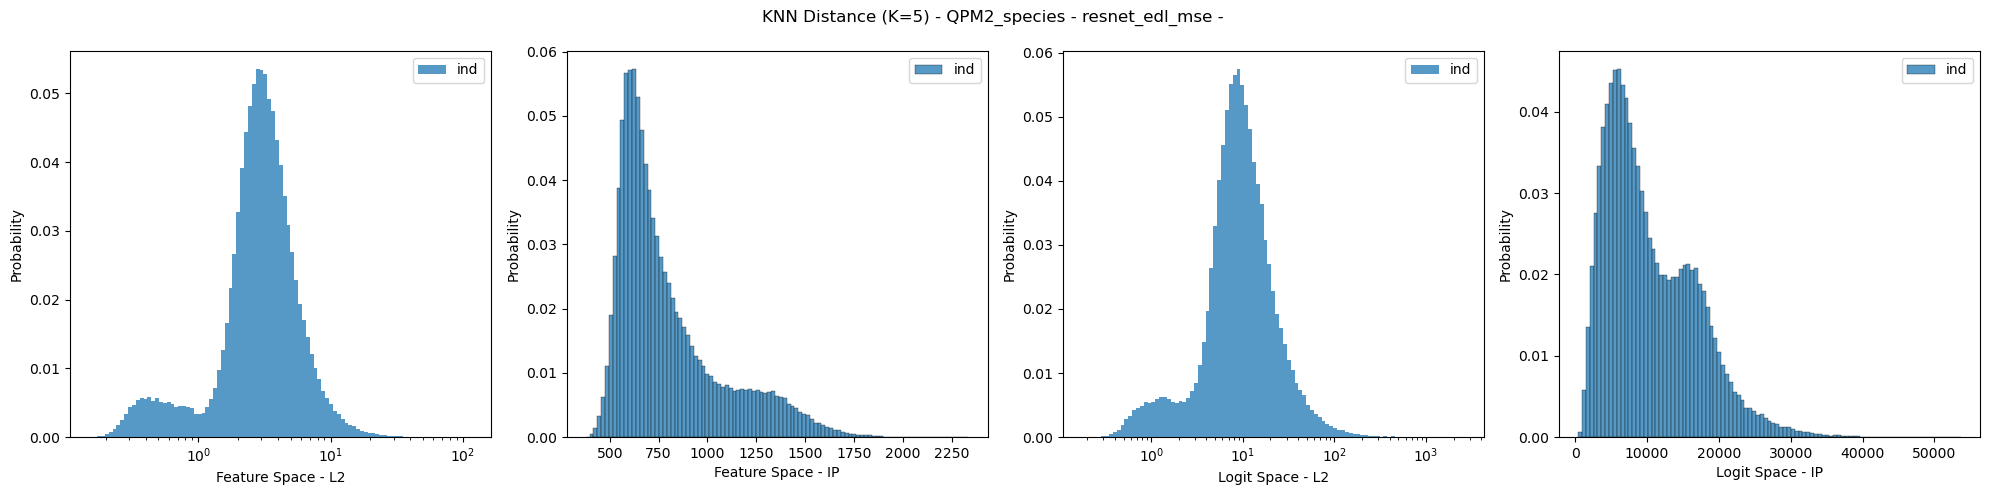

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

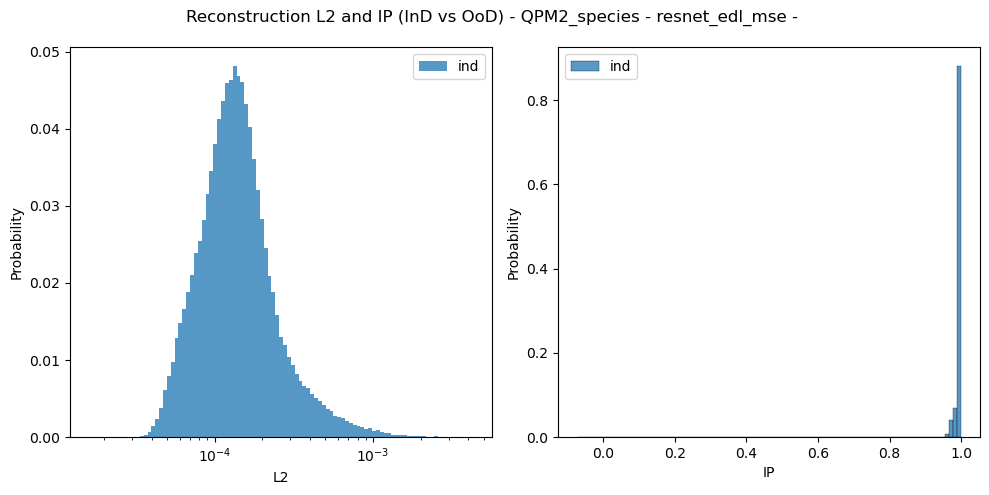

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

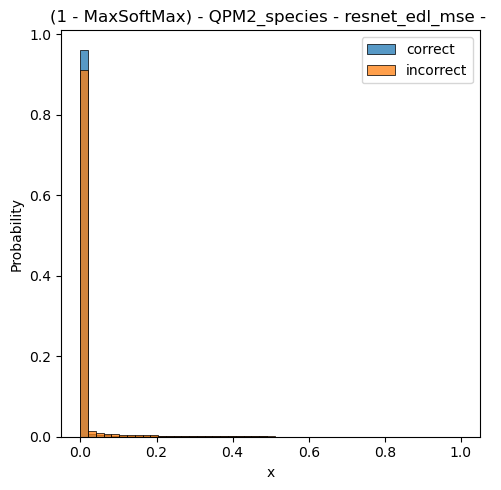

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

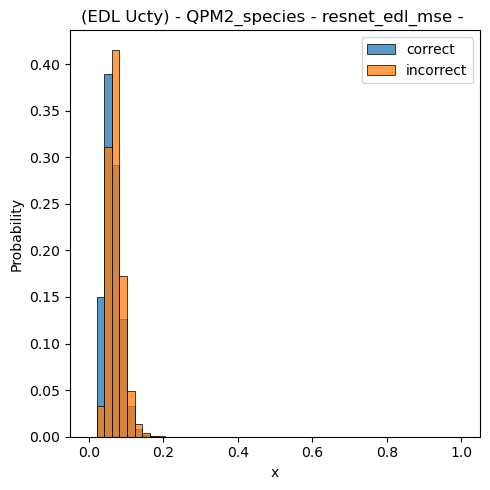

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()